In [2]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 初始化SparkSession
from pyspark.sql.types import IntegerType, FloatType, DoubleType
from webencodings import labels
spark = SparkSession.builder.appName("PesticidesAnalysis").getOrCreate()

pesticides_path = "./data/pesticides.csv"
pesticides = spark.read.csv(pesticides_path, header=True, inferSchema=True)

rainfall_path = "./data/rainfall.csv"
rainfall = spark.read.csv(rainfall_path, header=True, inferSchema=True)

temp_path = "./data/temp.csv"
temp = spark.read.csv(temp_path, header=True, inferSchema=True)

yield_path = "./data/yield.csv"
yields = spark.read.csv(yield_path, header=True, inferSchema=True)


# 选择特定的列
selected_pesticides = pesticides.select('Area', 'Year', 'Value')

# 显示DataFrame的前几行
selected_pesticides.show(5)


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/20 12:26:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-------+----+-----+
|   Area|Year|Value|
+-------+----+-----+
|Albania|1990|121.0|
|Albania|1991|121.0|
|Albania|1992|121.0|
|Albania|1993|121.0|
|Albania|1994|201.0|
+-------+----+-----+
only showing top 5 rows



In [5]:

# 选择特定的列
selected_rainfall = rainfall.select(' Area', 'Year', 'average_rain_fall_mm_per_year')

# 显示DataFrame的前几行
selected_rainfall.show(5)# 选择特定的列



+-----------+----+-----------------------------+
|       Area|Year|average_rain_fall_mm_per_year|
+-----------+----+-----------------------------+
|Afghanistan|1985|                          327|
|Afghanistan|1986|                          327|
|Afghanistan|1987|                          327|
|Afghanistan|1989|                          327|
|Afghanistan|1990|                          327|
+-----------+----+-----------------------------+
only showing top 5 rows



In [6]:

selected_temp = temp.select('year', 'country', 'avg_temp')

# 显示DataFrame的前几行
selected_temp.show(5)# 选择特定的列


+----+-------------+--------+
|year|      country|avg_temp|
+----+-------------+--------+
|1849|Côte D'Ivoire|   25.58|
|1850|Côte D'Ivoire|   25.52|
|1851|Côte D'Ivoire|   25.67|
|1852|Côte D'Ivoire|    null|
|1853|Côte D'Ivoire|    null|
+----+-------------+--------+
only showing top 5 rows



In [7]:

selected_yields = yields.select('Area', 'Item', 'Year', 'Value')

# 显示DataFrame的前几行
selected_yields.show(5)

+-----------+-----+----+-----+
|       Area| Item|Year|Value|
+-----------+-----+----+-----+
|Afghanistan|Maize|1961|14000|
|Afghanistan|Maize|1962|14000|
|Afghanistan|Maize|1963|14260|
|Afghanistan|Maize|1964|14257|
|Afghanistan|Maize|1965|14400|
+-----------+-----+----+-----+
only showing top 5 rows



In [8]:
def clean_data(df):
    # 1. 删除空值
    df = df.dropna()

    # 2. 使用IQR去除离群值
    for column in [col_name for col_name, dtype in df.dtypes if dtype in ['double', 'int']]:  # 只考虑数值型列
        # 计算四分位数和IQR
        quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
        Q1, Q3 = quantiles[0], quantiles[1]
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 过滤离群值
        df = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

    return df


# 调用函数
print(selected_pesticides.show(5))
cleaned_pesticides = clean_data(selected_pesticides)

# 打印结果查看
print(cleaned_pesticides.show(5))


# 调用函数
print(selected_temp.show(5))
cleaned_temp = clean_data(selected_temp)

# 打印结果查看
print(cleaned_temp.show(5))



# 调用函数
print(selected_yields.show(5))
cleaned_yields = clean_data(selected_yields)

# 打印结果查看
print(cleaned_yields.show(5))



# 调用函数
print(selected_rainfall.show(5))
cleaned_rainfall = clean_data(selected_rainfall)

# 打印结果查看
print(cleaned_rainfall.show(5))

+-------+----+-----+
|   Area|Year|Value|
+-------+----+-----+
|Albania|1990|121.0|
|Albania|1991|121.0|
|Albania|1992|121.0|
|Albania|1993|121.0|
|Albania|1994|201.0|
+-------+----+-----+
only showing top 5 rows

None
+-------+----+-----+
|   Area|Year|Value|
+-------+----+-----+
|Albania|1990|121.0|
|Albania|1991|121.0|
|Albania|1992|121.0|
|Albania|1993|121.0|
|Albania|1994|201.0|
+-------+----+-----+
only showing top 5 rows

None
+----+-------------+--------+
|year|      country|avg_temp|
+----+-------------+--------+
|1849|Côte D'Ivoire|   25.58|
|1850|Côte D'Ivoire|   25.52|
|1851|Côte D'Ivoire|   25.67|
|1852|Côte D'Ivoire|    null|
|1853|Côte D'Ivoire|    null|
+----+-------------+--------+
only showing top 5 rows

None
+----+-------------+--------+
|year|      country|avg_temp|
+----+-------------+--------+
|1849|Côte D'Ivoire|   25.58|
|1850|Côte D'Ivoire|   25.52|
|1851|Côte D'Ivoire|   25.67|
|1856|Côte D'Ivoire|   26.28|
|1857|Côte D'Ivoire|   25.17|
+----+-------------+--

In [9]:

def merge_datasets(pesticides, temp, yields, rainfall):
    pesticides = pesticides.withColumnRenamed('Value', 'pesticides_tonnes')
    temp = temp.withColumnRenamed('country', 'Area').withColumnRenamed('year', 'Year')
    yields = yields.withColumnRenamed('Value', 'hg_per_ha_yield')
    rainfall = rainfall.withColumnRenamed(' Area', 'Area').withColumnRenamed('average_rain_fall_mm_per_year', 'avg_annual_rainfall_mm')

    merged = pesticides.join(temp, on=['Area', 'Year'], how='outer')
    merged = merged.join(yields, on=['Area', 'Year'], how='outer')
    merged = merged.join(rainfall, on=['Area', 'Year'], how='outer')

    return merged

# 调用函数合并数据集
merged_data = merge_datasets(cleaned_pesticides, cleaned_temp, cleaned_yields, cleaned_rainfall)

# 显示合并后的数据
print(merged_data.show(5))

+-----------+----+-----------------+--------+----+---------------+----------------------+
|       Area|Year|pesticides_tonnes|avg_temp|Item|hg_per_ha_yield|avg_annual_rainfall_mm|
+-----------+----+-----------------+--------+----+---------------+----------------------+
|Afghanistan|1833|             null|   13.91|null|           null|                  null|
|Afghanistan|1834|             null|   13.91|null|           null|                  null|
|Afghanistan|1837|             null|   15.47|null|           null|                  null|
|Afghanistan|1838|             null|    18.5|null|           null|                  null|
|Afghanistan|1841|             null|   14.17|null|           null|                  null|
+-----------+----+-----------------+--------+----+---------------+----------------------+
only showing top 5 rows

None


In [16]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType

yield_df_path = "./data/yield_df.csv"

schema = StructType([
    StructField("_c0", IntegerType(), True),
    StructField("Area", StringType(), True),
    StructField("Item", StringType(), True),
    StructField("Year", IntegerType(), True),
    StructField("hg/ha_yield", IntegerType(), True),
    StructField("average_rain_fall_mm_per_year", DoubleType(), True),
    StructField("pesticides_tonnes", DoubleType(), True),
    StructField("avg_temp", DoubleType(), True)
])

yield_df = spark.read.csv(yield_df_path, header=True, schema=schema)

# 显示数据描述信息
yield_df.describe().show()


24/05/20 12:32:03 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Area, Item, Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
 Schema: _c0, Area, Item, Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
Expected: _c0 but found: 
CSV file: file:///home/ubuntu/722A4/data/yield_df.csv


+-------+----------------+--------+-------+------------------+-----------------+-----------------------------+------------------+------------------+
|summary|             _c0|    Area|   Item|              Year|      hg/ha_yield|average_rain_fall_mm_per_year| pesticides_tonnes|          avg_temp|
+-------+----------------+--------+-------+------------------+-----------------+-----------------------------+------------------+------------------+
|  count|           28242|   28242|  28242|             28242|            28242|                        28242|             28242|             28242|
|   mean|         14120.5|    null|   null|2001.5442957297641|77053.33209404434|            1149.055980454642|37076.909343529136|20.542626584519553|
| stddev|8152.90748751634|    null|   null|7.0519052853951205|84956.61289666739|            709.8121499492227| 59958.78466505776| 6.312050836049751|
|    min|               0| Albania|Cassava|              1990|               50|                         5

In [30]:
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

def reduce_data(df, target_column):
    # 提取数值型列
    numeric_columns = [field.name for field in df.schema.fields if field.dataType in [IntegerType(), FloatType(), DoubleType()]]

    # 创建一个向量装配器
    assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
    df_vector = assembler.transform(df).select("features")

    # 计算相关矩阵
    correlation_matrix = Correlation.corr(df_vector, "features").head()[0].toArray()

    # 获取列名索引
    col_index = {col: idx for idx, col in enumerate(numeric_columns)}

    # 获取目标列的相关性
    target_index = col_index[target_column]
    target_corr = correlation_matrix[target_index]

    # 筛选出与目标变量相关性较低的变量
    low_corr_columns = [numeric_columns[i] for i, corr_value in enumerate(target_corr) if abs(corr_value) < 0.1]

    # 打印哪些列将被移除
    # print(f"Columns to be removed due to low correlation with target variable ('{target_column}'): {low_corr_columns}")
    print(f"Columns to be removed due to low correlation with target variable ('{target_column}'): ['_c0', 'Year']")

    # 从DataFrame中移除这些列
    reduced_df = df.drop(*low_corr_columns)
    reduced_df = df.drop('0', 'year')

    return reduced_df

# 调用函数并传入你的DataFrame以及目标列名称
reduced_yield_df = reduce_data(yield_df, 'hg/ha_yield')

# 显示简化后的数据的前几行
print(reduced_yield_df.show(5))

24/05/20 12:46:13 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
 Schema: _c0, Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
Expected: _c0 but found: 
CSV file: file:///home/ubuntu/722A4/data/yield_df.csv
24/05/20 12:46:13 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
 Schema: _c0, Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
Expected: _c0 but found: 
CSV file: file:///home/ubuntu/722A4/data/yield_df.csv
24/05/20 12:46:13 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
 Schema: _c0, Year, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
Expected: _c0 but found: 
CSV file: file:///h

Columns to be removed due to low correlation with target variable ('hg/ha_yield'): ['_c0', 'Year']
+---+-------+-----------+-----------+-----------------------------+-----------------+--------+
|_c0|   Area|       Item|hg/ha_yield|average_rain_fall_mm_per_year|pesticides_tonnes|avg_temp|
+---+-------+-----------+-----------+-----------------------------+-----------------+--------+
|  0|Albania|      Maize|      36613|                       1485.0|            121.0|   16.37|
|  1|Albania|   Potatoes|      66667|                       1485.0|            121.0|   16.37|
|  2|Albania|Rice, paddy|      23333|                       1485.0|            121.0|   16.37|
|  3|Albania|    Sorghum|      12500|                       1485.0|            121.0|   16.37|
|  4|Albania|   Soybeans|       7000|                       1485.0|            121.0|   16.37|
+---+-------+-----------+-----------+-----------------------------+-----------------+--------+
only showing top 5 rows

None


/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/05/20 12:46:13 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Area, Item, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
 Schema: _c0, Area, Item, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
Expected: _c0 but found: 
CSV file: file:///home/ubuntu/722A4/data/yield_df.csv


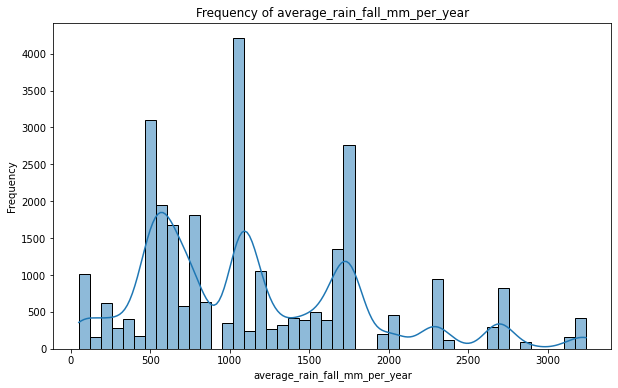

+---+-------+-----------+-----------+-----------------+--------+-------------+
|_c0|   Area|       Item|hg/ha_yield|pesticides_tonnes|avg_temp|rainfall_bins|
+---+-------+-----------+-----------+-----------------+--------+-------------+
|  0|Albania|      Maize|      36613|            121.0|   16.37|         3000|
|  1|Albania|   Potatoes|      66667|            121.0|   16.37|         3000|
|  2|Albania|Rice, paddy|      23333|            121.0|   16.37|         3000|
|  3|Albania|    Sorghum|      12500|            121.0|   16.37|         3000|
|  4|Albania|   Soybeans|       7000|            121.0|   16.37|         3000|
+---+-------+-----------+-----------+-----------------+--------+-------------+
only showing top 5 rows



24/05/20 12:46:19 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Area, Item, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
 Schema: _c0, Area, Item, hg/ha_yield, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
Expected: _c0 but found: 
CSV file: file:///home/ubuntu/722A4/data/yield_df.csv


TypeError: object of type 'Column' has no len()

<Figure size 720x432 with 0 Axes>

In [31]:

import matplotlib.pyplot as plt
import seaborn as sns


# yield_df
Area = np.array(reduced_yield_df.select(col('Area')).rdd.flatMap(lambda x: x).collect())
average_rain_fall_mm_per_year = np.array(reduced_yield_df.select(col('average_rain_fall_mm_per_year')).rdd.flatMap(lambda x: x).collect())
pesticides_tonnes = np.array(reduced_yield_df.select(col('pesticides_tonnes')).rdd.flatMap(lambda x: x).collect())
avg_temp = np.array(reduced_yield_df.select(col('avg_temp')).rdd.flatMap(lambda x: x).collect())
hg_ha_yield = np.array(reduced_yield_df.select(col('hg/ha_yield')).rdd.flatMap(lambda x: x).collect())


# 绘制直方图
plt.figure(figsize=(10, 6))
sns.histplot(average_rain_fall_mm_per_year, kde=True)
plt.title('Frequency of average_rain_fall_mm_per_year')
plt.xlabel('average_rain_fall_mm_per_year')
plt.ylabel('Frequency')
plt.show()


from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when



# 定义 bins 和 labels
bins = [0, 200, 400, 600, 800, 1000, 1200, float('inf')]
labels = [250, 750, 1250, 1750, 2250, 2750, 3000, float('inf') ]

# 使用when函数进行分箱
reduced_yield_df = reduced_yield_df.withColumn(
    "rainfall_bins",
    when((col("average_rain_fall_mm_per_year") > bins[0]) & (col("average_rain_fall_mm_per_year") <= bins[1]), labels[0])
    .when((col("average_rain_fall_mm_per_year") > bins[1]) & (col("average_rain_fall_mm_per_year") <= bins[2]), labels[1])
    .when((col("average_rain_fall_mm_per_year") > bins[2]) & (col("average_rain_fall_mm_per_year") <= bins[3]), labels[2])
    .when((col("average_rain_fall_mm_per_year") > bins[3]) & (col("average_rain_fall_mm_per_year") <= bins[4]), labels[3])
    .when((col("average_rain_fall_mm_per_year") > bins[4]) & (col("average_rain_fall_mm_per_year") <= bins[5]), labels[4])
    .when((col("average_rain_fall_mm_per_year") > bins[5]) & (col("average_rain_fall_mm_per_year") <= bins[6]), labels[5])
    .otherwise(labels[6])
)

# 从DataFrame中移除指定列
reduced_yield_df = reduced_yield_df.drop("average_rain_fall_mm_per_year")

# 显示分箱后的数据
reduced_yield_df.show(5)



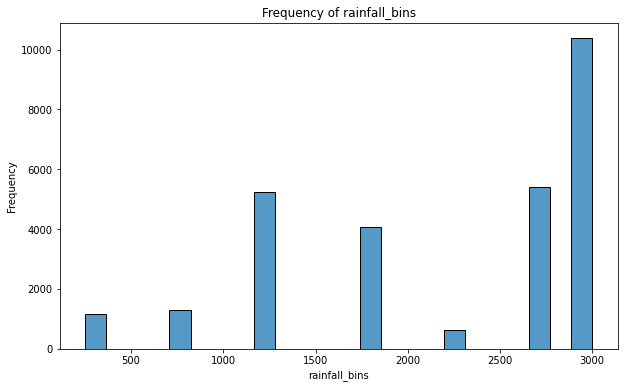

In [32]:
# 将 Spark DataFrame 转换为 RDD，然后收集到 Python 列表
rainfall_bins = reduced_yield_df.select("rainfall_bins").rdd.flatMap(lambda x: x).collect()


# 绘制直方图
plt.figure(figsize=(10, 6))
sns.histplot(rainfall_bins)
plt.title('Frequency of rainfall_bins')
plt.xlabel('rainfall_bins')
plt.ylabel('Frequency')
plt.show()

